PART 1

In [2]:
!pip install clean-text
!pip install --user -U nltk


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\welin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\welin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Niller\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Niller\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
df = pd.read_csv('news_sample.csv')
# define regular expressions for cleaning
num_re = re.compile(r"\d+")
# Formatting dates with YYYY-MM-DD since that's how it's formatted in the columns of the data.
date_re = re.compile(r"\d{4}-\d{2}-\d{2}")
email_re = re.compile(r"\S+@\S+")
url_re = re.compile(r"https?://\S+")
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
tokenlist = []
stopwordlist = []
stemmedlist = []
vocabulary_size = []
filtered_vocabulary_size = []
stemmed_vocabulary_size = []
def clean_text(text):
    # lower case all words
    text = text.lower()
    # replace multiple white spaces, tabs, or new lines with a single space
    text = re.sub(r"\s+", " ", text)
    # replace numbers, dates, emails, and URLs with special tokens
    text = date_re.sub("<DATE>", text)
    text = email_re.sub("<EMAIL>", text)
    text = url_re.sub("<URL>", text)
    text = num_re.sub("<NUM>", text)
    tokens = word_tokenize(text)
    # Removing tokens that come from tags
    tags = ['<','>','num','date','email','url']
    filtered_tokens = []
    for token in tokens:
        if token.lower() not in tags and re.match(r'^\w', token):
            filtered_tokens.append(token)
    # Removing stopwords
    tokenlist.append(filtered_tokens)
    stopwordless_tokens = []
    for token in filtered_tokens:
        if token.lower() not in stop_words:
            stopwordless_tokens.append(token)
    stopwordlist.append(stopwordless_tokens)
    # Perform stemming
    stemmed_tokens = [stemmer.stem(token) for token in stopwordless_tokens]
    stemmedlist.append(stemmed_tokens)
    # Compute vocabulary size before and after removing stopwords and stemming
    vocabulary_size.append(len(set(filtered_tokens)))
    filtered_vocabulary_size.append(len(set(stopwordless_tokens)))
    stemmed_vocabulary_size.append(len(set(stemmed_tokens)))
    stemmedtext = ' '.join(stemmed_tokens)
    return (stemmedtext)


df['content'] = df['content'].apply(clean_text)
vocab_sum = sum(vocabulary_size)
filtered_sum= sum(filtered_vocabulary_size)
stemmed_sum = sum(stemmed_vocabulary_size)
print("Vocabulary size:", vocab_sum ) 
print("Vocabulary size without stopwords:",  filtered_sum, ", resulting in reduction rate:", filtered_sum/vocab_sum)
print("Vocabulary size after stemming with no stopwords:", stemmed_sum, ", resulting in reduction rate:", stemmed_sum/filtered_sum)

print(df)


Vocabulary size: 72230
Vocabulary size without stopwords: 59307 , resulting in reduction rate: 0.8210854215699848
Vocabulary size after stemming with no stopwords: 53917 , resulting in reduction rate: 0.9091169676429427
     Unnamed: 0     id                domain        type  \
0             0    141               awm.com  unreliable   
1             1    256     beforeitsnews.com        fake   
2             2    700           cnnnext.com  unreliable   
3             3    768               awm.com  unreliable   
4             4    791  bipartisanreport.com   clickbait   
..          ...    ...                   ...         ...   
245         245  39259     beforeitsnews.com        fake   
246         246  39468     beforeitsnews.com        fake   
247         247  39477       www.newsmax.com         NaN   
248         248  39550       www.newsmax.com         NaN   
249         249  39558       www.newsmax.com         NaN   

                                                   url  \
0

PART 1.1

PART 1.2


Observations: 

  1.All articles from www.newsmax.com, willyloman.wordpress and wallstreetonparade.com do not have a type.

2. The ids go up with the article order

3. The average amount of stemmed words change with each type, this is however a small sample size for a lot of the types.

4. The count of types vary a lot, 62% are "fake", yet only 1/250 is "clickbait" or "hate".

5. The words a more evenly spread without stopwords (see graphs below)


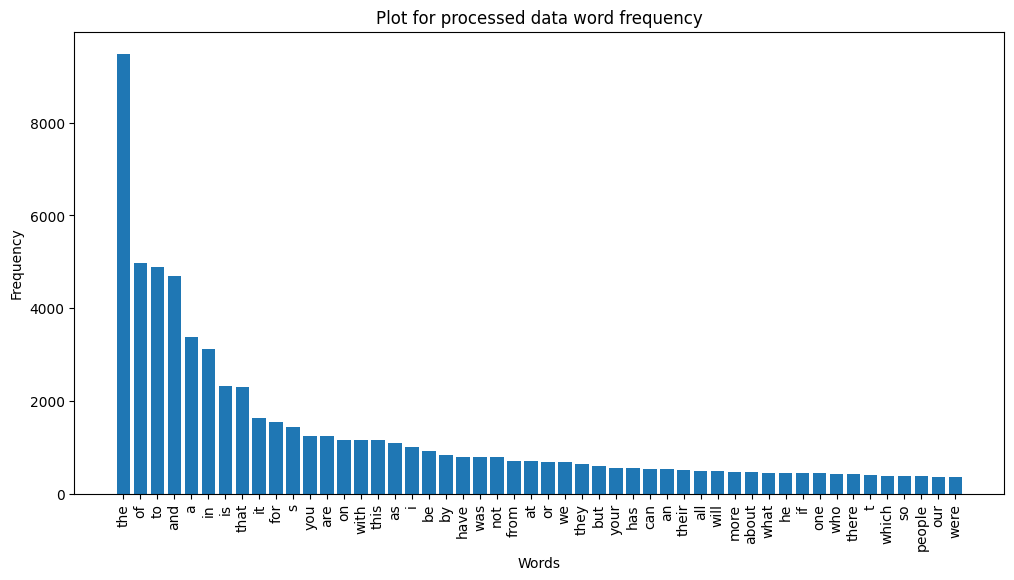

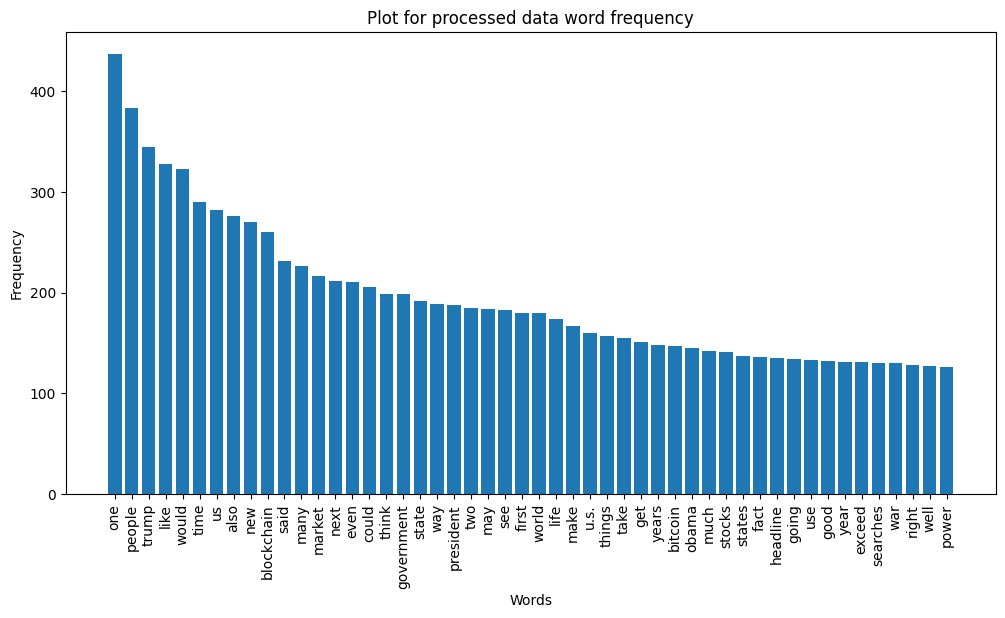

In [13]:

from collections import Counter
import matplotlib.pyplot as plt
# Use Counter to count the frequency of each word
word_counts = Counter(sum(tokenlist, []))

# Get the 50 most common words
top_words = word_counts.most_common(50)

# Separate out the words and their counts
word_labels = [word[0] for word in top_words]
word_freqs = [word[1] for word in top_words]

# Plot a bar chart of the top 50 words
plt.figure(figsize=(12, 6))
plt.title('Plot for processed data word frequency')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.bar(word_labels, word_freqs)
plt.xticks(rotation=90)
plt.show()


word_counts = Counter(sum(stopwordlist, []))
top_words = word_counts.most_common(50)

# Separate out the words and their counts
word_labels = [word[0] for word in top_words]
word_freqs = [word[1] for word in top_words]

# Plot a bar chart of the top 50 words
plt.figure(figsize=(12, 6))
plt.title('Plot for processed data word frequency')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.bar(word_labels, word_freqs)
plt.xticks(rotation=90)
plt.show()

PART 1.3

In [23]:

df = pd.read_csv('news_cleaned_2018_02_13.csv',nrows=50000)
# define regular expressions for cleaning
num_re = re.compile(r"\d+")
# Formatting dates with YYYY-MM-DD since that's how it's formatted in the columns of the data.
date_re = re.compile(r"\d{4}-\d{2}-\d{2}")
email_re = re.compile(r"\S+@\S+")
url_re = re.compile(r"https?://\S+")
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
tokenlist = []
stopwordlist = []
stemmedlist = []
vocabulary_size = []
filtered_vocabulary_size = []
stemmed_vocabulary_size = []
def clean_text(text):
    # lower case all words
    text = text.lower()
    # replace multiple white spaces, tabs, or new lines with a single space
    text = re.sub(r"\s+", " ", text)
    # replace numbers, dates, emails, and URLs with special tokens
    text = date_re.sub("<DATE>", text)
    text = email_re.sub("<EMAIL>", text)
    text = url_re.sub("<URL>", text)
    text = num_re.sub("<NUM>", text)
    tokens = word_tokenize(text)
    # Removing tokens that come from tags
    tags = ['<','>','num','date','email','url']
    filtered_tokens = []
    for token in tokens:
        if token.lower() not in tags and re.match(r'^\w', token):
            filtered_tokens.append(token)
    # Removing stopwords
    tokenlist.append(filtered_tokens)
    stopwordless_tokens = []
    for token in filtered_tokens:
        if token.lower() not in stop_words:
            stopwordless_tokens.append(token)
    stopwordlist.append(stopwordless_tokens)
    # Perform stemming
    stemmed_tokens = [stemmer.stem(token) for token in stopwordless_tokens]
    stemmedlist.append(stemmed_tokens)
    # Compute vocabulary size before and after removing stopwords and stemming
    vocabulary_size.append(len(set(filtered_tokens)))
    filtered_vocabulary_size.append(len(set(stopwordless_tokens)))
    stemmed_vocabulary_size.append(len(set(stemmed_tokens)))
    stemmedtext = ' '.join(stemmed_tokens)
    return (stemmedtext)


df['content'] = df['content'].apply(clean_text)
vocab_sum = sum(vocabulary_size)
filtered_sum= sum(filtered_vocabulary_size)
stemmed_sum = sum(stemmed_vocabulary_size)
print("Vocabulary size:", vocab_sum ) 
print("Vocabulary size without stopwords:",  filtered_sum, ", resulting in reduction rate:", filtered_sum/vocab_sum)
print("Vocabulary size after stemming with no stopwords:", stemmed_sum, ", resulting in reduction rate:", stemmed_sum/filtered_sum)

print(df)


Vocabulary size: 13673147
Vocabulary size without stopwords: 11159412 , resulting in reduction rate: 0.8161553444865326
Vocabulary size after stemming with no stopwords: 10244734 , resulting in reduction rate: 0.9180352871638756
       Unnamed: 0     id              domain       type  \
0               0      2       express.co.uk      rumor   
1               1      6  barenakedislam.com       hate   
2               2      7  barenakedislam.com       hate   
3               3      8  barenakedislam.com       hate   
4               4      9  barenakedislam.com       hate   
...           ...    ...                 ...        ...   
49995        9995  55279   beforeitsnews.com       fake   
49996        9996  55280   beforeitsnews.com       fake   
49997        9997  55281  weeklystandard.com  political   
49998        9998  55282       breitbart.com  political   
49999        9999  55283   beforeitsnews.com       fake   

                                                     url  \
0 

In [5]:
train_data, temp_data = train_test_split(df, test_size=0.2)

# Split the temporary data into validation and test sets (50/50 split)
valid_data, test_data = train_test_split(temp_data, test_size=0.5)


In [24]:

unique_values = df['type'].unique()

# print the unique values
print(unique_values)


['rumor' 'hate' 'unreliable' 'conspiracy' 'clickbait' 'satire' 'fake'
 'reliable' 'bias' 'political' 'junksci' nan 'unknown']


Fake :  rumor, hate, unreliable, conspicary, clickbait, satire, fake, bias, junksci
True: Reliable, Politcal

In [25]:
# create a dictionary to map the values to "fake" or "true"
mapping = {'rumor': 'fake',
           'hate': 'fake',
           'unreliable': 'fake',
           'conspiracy': 'fake',
           'clickbait': 'fake',
           'satire': 'fake',
           'fake': 'fake',
           'bias': 'fake',
           'junksci': 'fake',
           'political': 'reliable'}

# replace the values using the mapping dictionary
df['type'] = df['type'].replace(mapping)
# filter out the rows where 'Column1' is not equal to either "true" or "fake"
df = df[(df['type'] == 'reliable') | (df['type'] == 'fake')]

In [26]:

unique_values = df['type'].unique()

# print the unique values
print(unique_values)

['fake' 'reliable']


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Create a CountVectorizer object to transform the documents into a bag of words representation
vectorizer = CountVectorizer()

# Fit the vectorizer to the documents and transform them into a matrix of word counts
bow_matrix = vectorizer.fit_transform(df['content'])

# Print the vocabulary of the vectorizer (the unique words in the corpus)
print(vectorizer.vocabulary_)

X_train, X_test, y_train, y_test = train_test_split(bow_matrix, df['type'], test_size=0.2, random_state=42)

# Train a logistic regression classifier on the training data
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

{'life': 74550, 'illus': 61217, 'least': 73348, 'quantum': 105543, 'level': 74088, 'theori': 130061, 'recent': 107591, 'confirm': 26338, 'set': 116827, 'research': 109338, 'final': 45129, 'mean': 80873, 'test': 129331, 'john': 66589, 'wheeler': 143078, 'delayed': 32162, 'choic': 23042, 'conclud': 26152, 'physicist': 99364, 'right': 110413, 'mr': 85833, 'propos': 103780, 'experi': 42706, 'involv': 64042, 'move': 85703, 'object': 92067, 'given': 51025, 'act': 1267, 'like': 74739, 'wave': 142058, 'particl': 96797, 'former': 46777, 'vibrat': 139683, 'frequenc': 47545, 'distinguish': 35107, 'latter': 72849, 'determin': 33387, 'posit': 101650, 'space': 121872, 'unlik': 136724, 'point': 100842, 'decid': 31584, 'one': 93391, 'time': 131138, 'technolog': 128524, 'avail': 9265, 'conduct': 26252, 'strong': 124696, 'scientist': 115170, 'abl': 524, 'carri': 20293, 'unfortun': 136351, 'yet': 146199, 'attack': 8724, 'islam': 64577, 'terrorism': 129265, 'connect': 26509, 'know': 70338, 'sever': 116897

d:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
